## Setup

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools
import tensorflow as tf
from PIL import Image
import os 
import cv2
import subprocess

print(tf.__version__)

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

2.12.0


## Load and Preprocess image

In [ ]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# resize and central crop
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)



* The content image and the style image must be RGB images with pixel values being float32 numbers between [0..1].
* The style image size must be (1, 384, 384, 3). We central crop the image and resize it.
* The content image must be (1, 256, 256, 3). We central crop the image and resize it.

## unzip content file

In [ ]:
!unzip /content/image_files.zip

Archive:  /content/image_files.zip
replace __MACOSX/._image_files? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Inference Functions

In [ ]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

## Save Output

In [ ]:
def save_output(oimg = None , op = None, cimg=None , cp = None , simg=None , sp = None):

  if cp:
    image_array = tf.squeeze(cimg).numpy()
    image_array = (image_array * 255.0).astype('uint8')
    image = Image.fromarray(image_array) 
    image.save(cp)

  if sp:
    image_array = tf.squeeze(simg).numpy()
    image_array = (image_array * 255.0).astype('uint8')
    image = Image.fromarray(image_array) 
    image.save(sp)

  if op:
    img = np.squeeze(oimg)
    # Scale the values to the range [0, 255] and convert to uint8
    img = (img * 255).astype(np.uint8)
    # Create a PIL Image object from the numpy array
    pil_img = Image.fromarray(img)
    # Save the PIL Image as a JPEG file
    pil_img.save(op)
    

## Get Single Inference

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)
Style Bottleneck Shape: (1, 1, 1, 100)
<class 'numpy.ndarray'>
(1, 384, 384, 3)


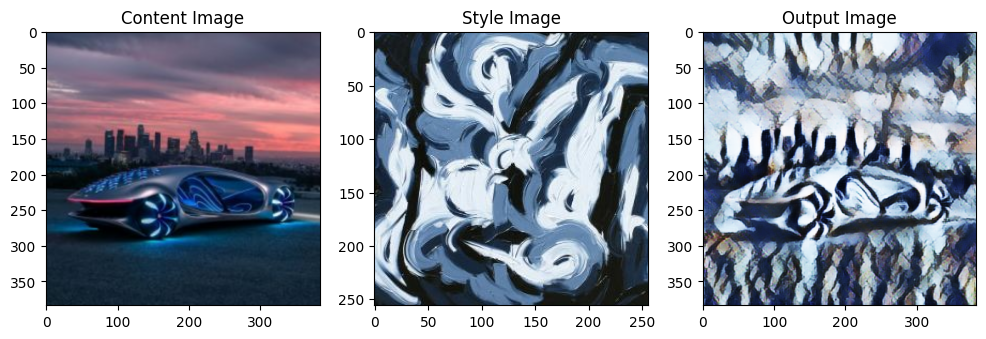

In [ ]:
content_path = "/content/image_files/content/car.jpg" # @param {type:"string"}
style_path = "/content/image_files/style/1.jpg" # @param {type:"string"}
output_path = "/content/output.jpg" # @param {type:"string"}

# tensor of shape (1,256,256,3)
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess 
preprocessed_content_image = preprocess_image(content_image, 384)
# preprocessed_content_image = preprocess_image(content_image, 256)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)
image_resized = cv2.resize(stylized_image[0], (256, 256), interpolation=cv2.INTER_LINEAR)
image_resized = np.expand_dims(image_resized, axis=0)
stylized_image = image_resized
# print(type(stylized_image))
# print(stylized_image.shape)

# Visualize the output.
# imshow(stylized_image, 'Stylized Image')
plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Content Image')
plt.subplot(1, 3, 2)
imshow(preprocessed_style_image, 'Style Image')
plt.subplot(1, 3, 3)
imshow(stylized_image, 'Output Image')

# save output
# save_output(cimg = preprocessed_content_image, cp = content_path, simg = preprocessed_style_image, sp = style_path, oimg = stylized_image, op = output_path)
save_output(oimg = stylized_image, op = output_path)


## Blend Input Image single Inference

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


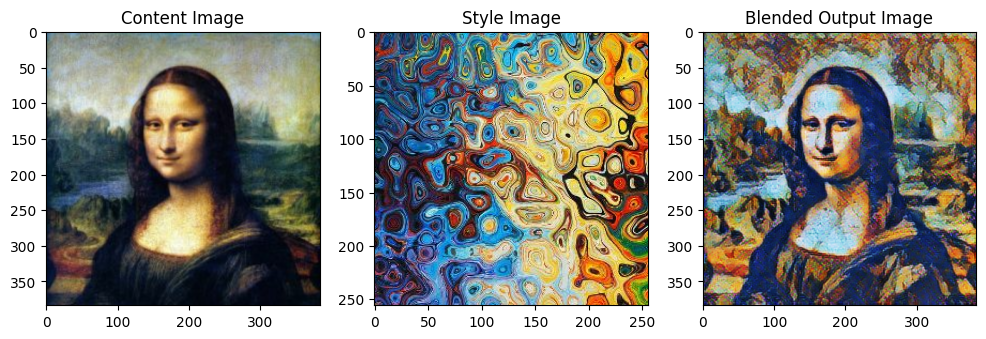

In [ ]:
content_path = "/content/ivc_images/content_256/lisa.jpg" # @param {type:"string"}
style_path = "/content/ivc_images/style_256/1.jpg" # @param {type:"string"}
output_path = "/content/output.jpg" # @param {type:"string"}

# tensor of shape (1,256,256,3)
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess 
preprocessed_content_image = preprocess_image(content_image, 384)
# preprocessed_content_image = preprocess_image(content_image, 256)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)


content_blending_ratio = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}

# Blend
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)


# Visualize the output.
# imshow(stylized_image, 'Stylized Image')
plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Content Image')
plt.subplot(1, 3, 2)
imshow(preprocessed_style_image, 'Style Image')
plt.subplot(1, 3, 3)
imshow(stylized_image_blended, 'Blended Output Image')

# save output
# save_output(cimg = preprocessed_content_image, cp = content_path, simg = preprocessed_style_image, sp = style_path, oimg = stylized_image_blended, op = output_path)
save_output(oimg = stylized_image_blended, op = output_path)


## Get Image Tuples

In [ ]:

content_dir = "/content/image_files/content" # @param {type:"string"}
style_dir = "/content/image_files/style" # @param {type:"string"}
out_dir = "/content/artistic_256" # @param {type:"string"}

# to get image tuples of only one style
only_one_style_all_images = False
style_image_name = ["1.jpg"]

image_tuples = []

if os.path.exists(out_dir):
  print("output directory already exist !")

elif only_one_style_all_images:
  for s in style_image_name:
    if ".DS_Store" in s:
      continue
    sn = s.split(".")[0]
    for c in os.listdir(content_dir):
      if ".DS_Store" in c:
        continue
      cn = c.split(".")[0]
      fsp = os.path.join(style_dir,s)
      fcp = os.path.join(content_dir,c)
      
      on = "content_"+str(cn)+"_style_"+str(sn)+".jpg"
      op = os.path.join(out_dir,on)
      image_tuples.append((fcp,fsp,op))

else:
  for s in os.listdir(style_dir):
    if ".DS_Store" in s:
      continue
    sn = s.split(".")[0]
    for c in os.listdir(content_dir):
      if ".DS_Store" in c:
        continue
      cn = c.split(".")[0]
      fsp = os.path.join(style_dir,s)
      fcp = os.path.join(content_dir,c)
      
      on = "content_"+str(cn)+"_style_"+str(sn)+".jpg"
      op = os.path.join(out_dir,on)
      image_tuples.append((fcp,fsp,op))

    # also make output directory if missing 
    subprocess.run("mkdir "+str(out_dir), shell = True)

for x in image_tuples:
  print(x)

('/content/image_files/content/car.jpg', '/content/image_files/style/2.jpg', '/content/artistic_256/content_car_style_2.jpg')
('/content/image_files/content/building.jpg', '/content/image_files/style/2.jpg', '/content/artistic_256/content_building_style_2.jpg')
('/content/image_files/content/person.jpg', '/content/image_files/style/2.jpg', '/content/artistic_256/content_person_style_2.jpg')
('/content/image_files/content/dog.jpg', '/content/image_files/style/2.jpg', '/content/artistic_256/content_dog_style_2.jpg')
('/content/image_files/content/painting.jpg', '/content/image_files/style/2.jpg', '/content/artistic_256/content_painting_style_2.jpg')
('/content/image_files/content/car.jpg', '/content/image_files/style/3.jpg', '/content/artistic_256/content_car_style_3.jpg')
('/content/image_files/content/building.jpg', '/content/image_files/style/3.jpg', '/content/artistic_256/content_building_style_3.jpg')
('/content/image_files/content/person.jpg', '/content/image_files/style/3.jpg', '/

## Get Multiple Inferences Blended

In [ ]:
print("Total Inferences: {}".format(len(image_tuples)))
count = 0
time_array = []

for t in image_tuples:
  cp, sp, op = t[0],t[1],t[2]
  count += 1
  print("Processing Inference :{}/{} for Image : {}".format(count, len(image_tuples), op))


  content_path = cp
  style_path = sp
  output_path = op

  # tensor of shape (1,256,256,3)
  content_image = load_img(content_path)
  style_image = load_img(style_path)

  # Preprocess 
  preprocessed_content_image = preprocess_image(content_image, 384)
  preprocessed_style_image = preprocess_image(style_image, 256)

  # print('Style Image Shape:', preprocessed_style_image.shape)
  # print('Content Image Shape:', preprocessed_content_image.shape)



  # time
  start_time = time.time()
  # Blend
  style_bottleneck_content = run_style_predict(
      preprocess_image(content_image, 256)
      )

  # Calculate style bottleneck for the preprocessed style image.
  style_bottleneck = run_style_predict(preprocessed_style_image)
  # print('Style Bottleneck Shape:', style_bottleneck.shape)

  content_blending_ratio = 0.6 #@param {type:"slider", min:0, max:1, step:0.01}
  style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                            + (1 - content_blending_ratio) * style_bottleneck

  stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                              preprocessed_content_image)

  # print(stylized_image_blended.shape)
  image_resized = cv2.resize(stylized_image_blended[0], (256, 256), interpolation=cv2.INTER_LINEAR)
  image_resized = np.expand_dims(image_resized, axis=0)
  stylized_image_blended = image_resized

  end_time = time.time()
  tat_time = end_time - start_time
  tat_time = tat_time * 1000
  time_array.append(tat_time)

  # plt.subplot(1, 3, 1)
  # imshow(preprocessed_content_image, 'Content Image')
  # plt.subplot(1, 3, 2)
  # imshow(preprocessed_style_image, 'Style Image')
  # plt.subplot(1, 3, 3)
  # imshow(stylized_image_blended, 'Blended Output Image')
  # save output
  # save_output(cimg = preprocessed_content_image, cp = content_path, simg = preprocessed_style_image, sp = style_path, oimg = stylized_image_blended, op = output_path)
  save_output(oimg = stylized_image_blended, op = output_path)

print("tat_times : {}".format(time_array))
print("tat_average: {}".format(np.mean(np.array(time_array))))


Total Inferences: 25
Processing Inference :1/25 for Image : /content/artistic_256/content_car_style_2.jpg
Processing Inference :2/25 for Image : /content/artistic_256/content_building_style_2.jpg
Processing Inference :3/25 for Image : /content/artistic_256/content_person_style_2.jpg
Processing Inference :4/25 for Image : /content/artistic_256/content_dog_style_2.jpg
Processing Inference :5/25 for Image : /content/artistic_256/content_painting_style_2.jpg
Processing Inference :6/25 for Image : /content/artistic_256/content_car_style_3.jpg
Processing Inference :7/25 for Image : /content/artistic_256/content_building_style_3.jpg
Processing Inference :8/25 for Image : /content/artistic_256/content_person_style_3.jpg
Processing Inference :9/25 for Image : /content/artistic_256/content_dog_style_3.jpg
Processing Inference :10/25 for Image : /content/artistic_256/content_painting_style_3.jpg
Processing Inference :11/25 for Image : /content/artistic_256/content_car_style_1.jpg
Processing Infer

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp -r /content/artistic_256 /content/drive/MyDrive/artistic_256